In [1]:
# Banded Peak Ranch

In [2]:
# need to upgrade odc-stac to fix keyerror issue for some tiles
!pip install -q odc-stac -U

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import matplotlib
import ipyleaflet
import sys
import os
#import dask_gateway
import planetary_computer
from rechunker import rechunk
sys.path.append('../sar_snowmelt_timing')
import s1_rtc_bs_utils
import contextily as ctx
import rioxarray as rxr
import skimage
import pathlib
import glob
import re
import time
import dask_gateway
import fsspec

In [4]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=20, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.9d577d227dfd46a29b6b2c45beb28a29/status


In [5]:
geojson = '../input/shapefiles/bpr.geojson'
bbox_gdf = gpd.read_file(geojson)

In [6]:
years = [2015,2016,2017,2018,2019,2020,2021,2022,2023]

In [7]:
resolution = 20

In [8]:
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

In [9]:
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2015-01-01',end_time='2023-12-31',polarization='all',resolution=resolution)
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds)
ts_ds = ts_ds.where(worldcover.isin(classes))

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [10]:
for year in years:
    print(f'Processing {year}...')
    melt_year = slice(f'{year}-02-01',f'{year}-09-30')
    if (year == 2015) | (year == 2016):
        ts_ds_oneyear = ts_ds.sel(time=melt_year).sel(band='vv')
    else:
        ts_ds_oneyear = ts_ds.sel(time=melt_year)
    runoffs_median = s1_rtc_bs_utils.get_runoff_onset(ts_ds_oneyear,num_acquisitions_during_melt_season=5)
    runoffs_median_computed = runoffs_median.compute()
    runoffs_median_computed.dt.dayofyear.rio.to_raster(f'../output/bpr/runoff_onset_{year}_{resolution}.tif')
print(f'Done!')

Processing 2015...


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 14
  p = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 10
  p = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2016...


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2017...


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2018...


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2019...


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2020...


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2021...


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2022...


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


Processing 2023...
Done!


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


In [11]:
geotiff_list = glob.glob(f'../output/bpr/runoff_onset_*_2*.tif')

year_list = []
for geotiff in geotiff_list:
    year_list.append(re.search("([0-9]{4})", geotiff).group(0))
year_list = [int(year) for year in year_list]

#Create variable used for time axis
time_var = xr.Variable('time', year_list)

# Load in and concatenate all individual GeoTIFFs
runoffs_allyears = xr.concat([rxr.open_rasterio(i) for i in geotiff_list],dim=time_var).squeeze().sortby('time')
runoffs_allyears_median = runoffs_allyears.median(dim='time')
anomalies = runoffs_allyears - runoffs_allyears_median

In [12]:
watershed0 = gpd.read_file('../input/shapefiles/NavajoRiver/NavajoRiver_Basin_toBPRGauge.shp')
watershed1 = gpd.read_file('../input/shapefiles/NavajoRiver/NavajoRiver_Basin_toOsoDiv.shp')
watershed = watershed0.union(watershed1).to_crs(ts_ds.rio.crs)

/tmp/ipykernel_1593/2510590331.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in runoffs_allyears_plot.axes.flatten():


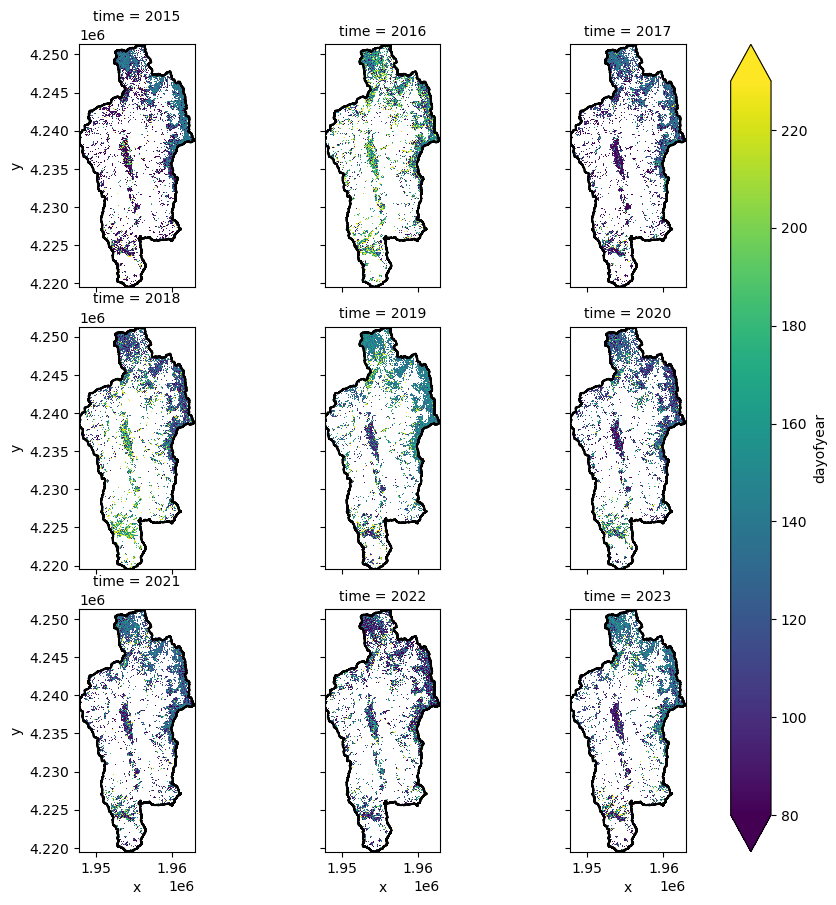

In [15]:
runoffs_allyears_plot = runoffs_allyears.where(runoffs_allyears>0).rio.clip(watershed.geometry.values,watershed.crs).plot(col='time',col_wrap=3,vmin=80,vmax=230)
for ax in runoffs_allyears_plot.axes.flatten():
    watershed.geometry.boundary.plot(ax=ax,color='black')

/tmp/ipykernel_1593/2265624726.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in anomalies_plot.axes.flatten():


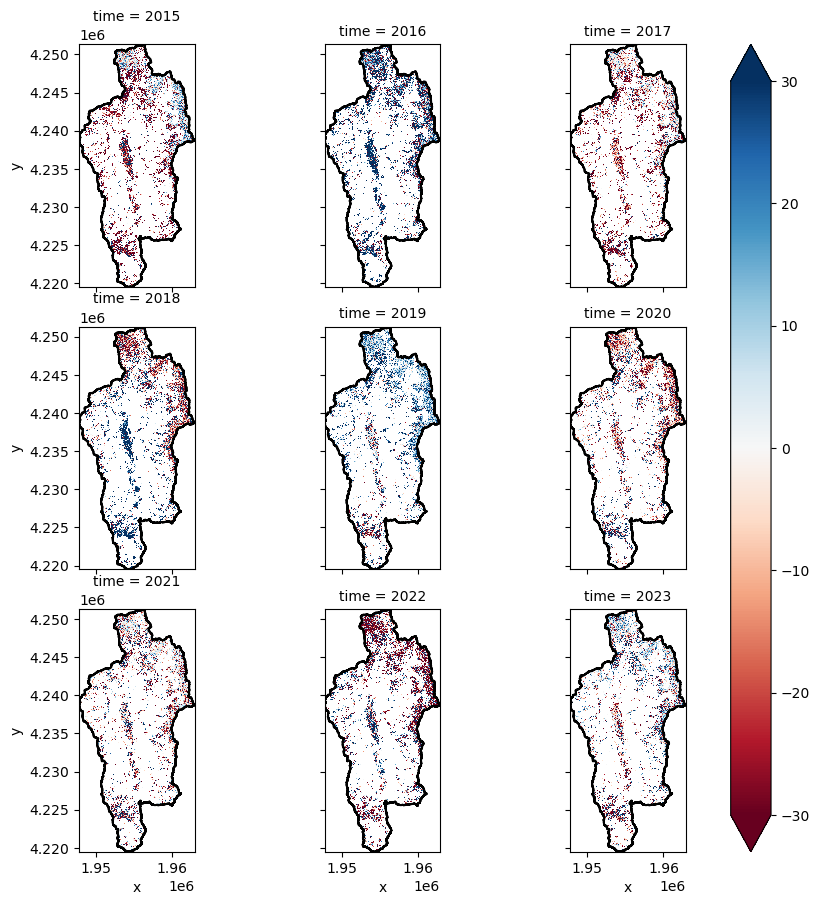

In [16]:
anomalies_plot = anomalies.where(runoffs_allyears>0).rio.clip(watershed.geometry.values,watershed.crs).plot(col='time',col_wrap=3,vmin=-30,vmax=30,cmap='RdBu')
for ax in anomalies_plot.axes.flatten():
    watershed.geometry.boundary.plot(ax=ax,color='black')